#Task 1 : Hierarchical clustering in non-Euclidean spaces

In [1]:
# Cell 1: Imports and Setup
from random import choice, randint
from string import ascii_letters
from collections import deque
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Limited Vocabulary Dataset Generation
vocab = ["".join(choice(ascii_letters) for _ in range(4)) for _ in range(10)]
records = []

for idx in range(10000):
    string_len = randint(32, 64)
    raw_string = ""

    while len(raw_string) < string_len:
        raw_string += choice(vocab)

    shingles = [raw_string[i:i+4] for i in range(len(raw_string) - 3)]
    records.append([idx, raw_string, shingles, len(raw_string)])

In [3]:
# Cell 3: Save to CSV
with open("dataset.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["index", "string", "shingles", "length"])
    writer.writerows(records)

In [4]:
# Cell 4: Load Dataset
df = pd.read_csv("dataset.csv", index_col="index")
df["shingles"] = df["shingles"].apply(literal_eval)

In [5]:
# Cell 5: Create Binary matrix
from itertools import chain

# Build vocabulary of all unique shingles
shingle_sets = df["shingles"].apply(set)
vocab = sorted(set(chain.from_iterable(shingle_sets)))
vocab_index = {sh: i for i, sh in enumerate(vocab)}
2
# Use int32 to prevent overflow
num_docs = len(df)
num_shingles = len(vocab)
binary_matrix = np.zeros((num_docs, num_shingles), dtype=np.int32)

# Populate matrix manually
for i, shingle_set in enumerate(shingle_sets):
    for sh in shingle_set:
        binary_matrix[i, vocab_index[sh]] = 1

In [6]:
# Cell 6: Agglomerative Clustering with NN-Chain and Progress
class CustomAgglomerativeClustering:
    """Bottom-up agglomerative clustering using clustroids and Jaccard distance."""

    def __init__(self, n_clusters=3, jump_threshold=None, seed=42, verbose=True, return_clustroids=False):
        self.n_clusters = n_clusters
        self.jump_threshold = jump_threshold
        self.seed = seed
        self.verbose = verbose
        self.return_clustroids = return_clustroids

    @staticmethod
    def jaccard_matrix(A, B):
        """Compute pairwise Jaccard distances using binary matrix form."""
        intersect = A.dot(B.T)
        union = A.shape[1] - (1 - A).dot(1 - B.T)
        return 1 - intersect / union

    def cluster(self, feature_matrix):
        clusters = pd.DataFrame(
            [(i, [i]) for i in range(len(feature_matrix))],
            columns=["clustroid", "members"]
        )

        rng = np.random.default_rng(self.seed)
        stack = deque()
        last_diameter = 0

        if self.verbose:
            pbar = tqdm(total=len(clusters) - self.n_clusters - 1, desc="Clustering")

        while len(clusters) > self.n_clusters + 1:
            if not stack:
                stack.appendleft(clusters["clustroid"].sample(1, random_state=rng).item())

            current = stack[0]
            candidates = clusters[clusters["clustroid"] != current]["clustroid"].values

            jaccard_distance = self.jaccard_matrix(feature_matrix[candidates], feature_matrix[[current]]).flatten()
            nearest = candidates[np.argmin(jaccard_distance)]

            if nearest in stack:
                stack.popleft()
                stack.remove(nearest)

                members = (
                    clusters.loc[clusters["clustroid"] == current, "members"].item() +
                    clusters.loc[clusters["clustroid"] == nearest, "members"].item()
                )

                submatrix = feature_matrix[members]
                jaccard_distance_matrix = self.jaccard_matrix(submatrix, submatrix)
                if self.jump_threshold is not None:
                    diameter = jaccard_distance_matrix.max()
                    if abs(diameter - last_diameter) > self.jump_threshold:
                        if self.verbose:
                            print(f"Jump threshold exceeded: Δ{abs(diameter - last_diameter):.4f}")
                        break
                    last_diameter = diameter

                clustroid = members[np.square(jaccard_distance_matrix).sum(axis=1).argmin()]
                clusters.loc[clusters["clustroid"] == current, "clustroid"] = clustroid
                clusters.loc[clusters["clustroid"] == nearest, "clustroid"] = clustroid
                clusters = clusters.groupby("clustroid", as_index=False).agg({"members": "sum"})

                if self.verbose:
                    pbar.update(1)
            else:
                stack.appendleft(nearest)

        if self.verbose:
            pbar.close()

        self.labels_ = clusters.explode("members").sort_values("members")["clustroid"].values

        return (self.labels_, clusters["clustroid"].values) if self.return_clustroids else self.labels_

    def cluster_and_label(self, X):
        return self.cluster(X)

In [7]:
# Cell 7: Run Clustering
clusterer = CustomAgglomerativeClustering(n_clusters=15, jump_threshold=0.8, seed=42, verbose=True)
labels = clusterer.cluster_and_label(binary_matrix)

Clustering: 100%|██████████| 9984/9984 [04:25<00:00, 37.59it/s]


In [8]:
# Cell 8: View Clustroids and Sample Strings
clustroid_ids = np.sort(np.unique(labels))
df.iloc[clustroid_ids]["string"]

,string
index,
508,tJqQymVwuNqctJqQtJqQHjKRuNqcslfFtJqQHjKRuNqc
649,ZQcVuNqcEJoCPkeSEJoCHjKRslfFElpeEJoCPkeSHjKREJ...
1981,slfFEJoCymVwPkeSuNqctJqQZQcVEJoCOZKkElpe
2026,HjKRtJqQEJoCtJqQPkeSHjKRElpeslfFHjKRHjKRuNqc
2251,HjKRHjKRslfFEJoCZQcVHjKRymVwHjKRuNqcOZKkHjKROZKk
2717,PkeSuNqcElpeslfFslfFuNqcymVwPkeSZQcVymVw
3639,PkeSZQcVHjKRymVwslfFslfFElpeElpeZQcVymVwElpetJ...
4538,PkeSZQcVslfFHjKRZQcVZQcVElpeymVwtJqQZQcVEJoCuN...
4885,PkeSslfFymVwEJoCOZKkymVwuNqcElpeEJoCymVwZQcVym...


In [12]:
# Cell 9: Average Intra-cluster Jaccard Distance
average_jaccard_distance_per_cluster = []

for clustroid_index in clustroid_ids:
    # Get all data point indices belonging to this cluster
    current_cluster_member_indices = np.where(labels == clustroid_index)[0]

    # Get binary vectors of all members and the clustroid
    current_cluster_members = binary_matrix[current_cluster_member_indices]
    clustroid_vector = binary_matrix[clustroid_index]

    # Compute intersection and union
    intersection = current_cluster_members.dot(clustroid_vector)
    union = binary_matrix.shape[1] - (1 - current_cluster_members).dot(1 - clustroid_vector)

    jaccard_distances = 1 - intersection / union
    average_jaccard_distance_per_cluster.append(jaccard_distances.mean())

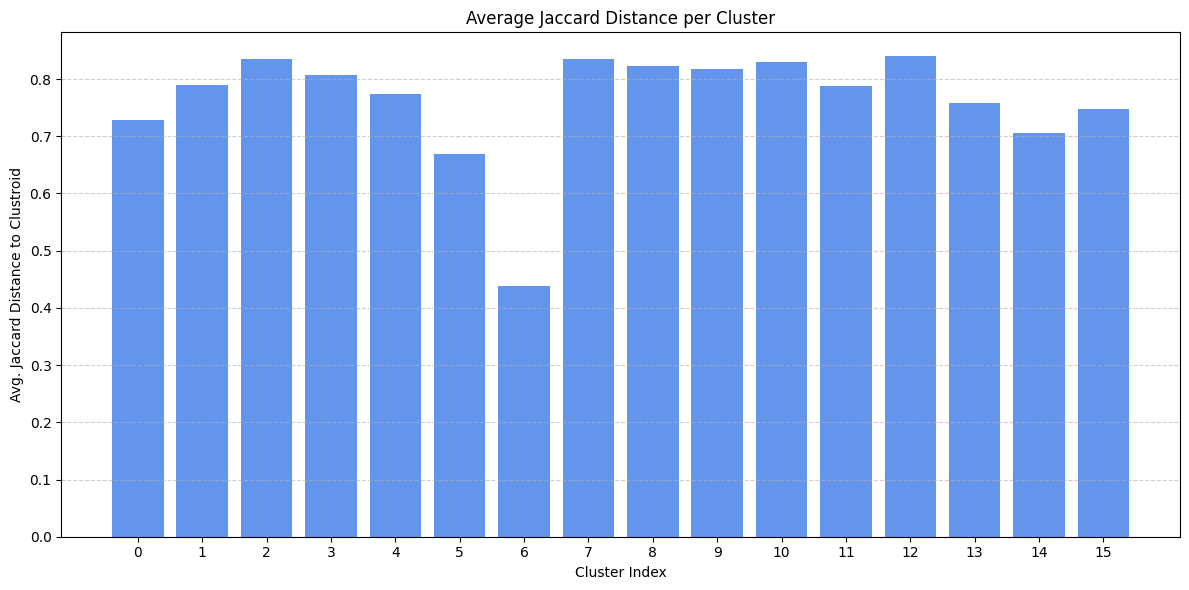

In [14]:
#Cell 10 : Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(average_jaccard_distance_per_cluster)), average_jaccard_distance_per_cluster, color='cornflowerblue')
plt.xlabel("Cluster Index")
plt.ylabel("Avg. Jaccard Distance to Clustroid")
plt.title("Average Jaccard Distance per Cluster")
plt.xticks(range(len(average_jaccard_distance_per_cluster)))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()